# Import 

In [1]:
!pip install spectral  
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.regularizers import l2
import pandas as pd
import numpy as np
from tensorflow import  keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import utils #np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

import tensorflow as tf
init_notebook_mode(connected=True)
%matplotlib inline

import spectral.io.envi as envi
from spectral import*
import matplotlib.pyplot as plt
import spectral

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
# function that gets the reflectance from intensities 
 
def get_reflectance(image):
  reflectance=np.zeros((image.shape))
  depth=image.shape[2]
  for lamda in range(depth):
    image_layer=image[:,:,lamda]
    radiance=image_layer.mean()
    reflectance[:,:,lamda]=image_layer.reshape(image.shape[:2])/radiance

  return reflectance


In [4]:
def change_2_triple_input(img_refl):
  # input image 
  img_refl.shape
  # pad image 
  img_refl_padded=np.zeros(  ( img_refl.shape[0] , img_refl.shape[1] + 2       ,  img_refl.shape[2]       ) )
  # create a bigger 
  # fill the inside 
  img_refl_padded[ : , 1:img_refl.shape[1] + 1 ,: ]= img_refl 
  #change to input size triple in each row
  img_refl_input=np.zeros( (img_refl_padded.shape[0]*(img_refl_padded.shape[1]-2),img_refl_padded.shape[2]*3) )
  counter=0
  for row in range(img_refl_padded.shape[0]): 
    for col in range( 1 , img_refl_padded.shape[1]- 1 ):   
      img_refl_input[counter,:] = img_refl_padded[row,col-1:col+2,:].reshape(1,img_refl_padded.shape[2]*3) # double check this step 
      counter=counter + 1;
  return img_refl_input


In [5]:
def form_label_matrix(img,img_string,df,draw):


  label_matrix_img=np.zeros(img.shape[:2])

  img_labeled=df.loc[img_string,["x","y","label"]]


  ## level one 
  i=0
  img_index_1=np.where(img_labeled["label"] == 'Level 1')

  img_labeled_1=img_labeled[["x","y"]].iloc[ img_index_1[0].tolist() ]

  img_labeled_1_x=img_labeled_1["x"].tolist()
  img_labeled_1_y=img_labeled_1["y"].tolist()

  for i in range(len(img_labeled_1_x)):
    x=int(img_labeled_1_x[i])
    y=int(img_labeled_1_y[i])
    label_matrix_img[y][x]=1

  ## level 3 
  i=0
  img_index_3=np.where(img_labeled["label"] == 'Level 3')

  img_labeled_3=img_labeled[["x","y"]].iloc[ img_index_3[0].tolist() ]

  img_labeled_3_x=img_labeled_3["x"].tolist()
  img_labeled_3_y=img_labeled_3["y"].tolist()

  for i in range(len(img_labeled_3_x)):
    x=int(img_labeled_3_x[i])
    y=int(img_labeled_3_y[i])
    label_matrix_img[y][x]=2

  ## level 4 
  i=0

  img_index_4=np.where(img_labeled["label"] == 'Level 4')  

  img_labeled_4=img_labeled[["x","y"]].iloc[ img_index_4[0].tolist() ]

  img_labeled_4_x=img_labeled_4["x"].tolist()
  img_labeled_4_y=img_labeled_4["y"].tolist()

  for i in range(len(img_labeled_4_x)):
    x=int(img_labeled_4_x[i])
    y=int(img_labeled_4_y[i])
    label_matrix_img[y][x] = 3 



  ## background 
  i=0 

  img_index_b=np.where(img_labeled["label"] == 'background') 

  img_labeled_b=img_labeled[["x","y"]].iloc[ img_index_b[0].tolist() ]

  img_labeled_b_x=img_labeled_b["x"].tolist()
  img_labeled_b_y=img_labeled_b["y"].tolist()

  for i in range(len(img_labeled_b_x)):
    x=int(img_labeled_b_x[i])
    y=int(img_labeled_b_y[i])
    label_matrix_img[y][x]=4 


  #draw

  # not labeled , 1, 3, 4 , b
  # black , blue , light blue , yellow, red
  if draw == 1:
    paint_cmap = ListedColormap(['#000000','#0000CD', '#00FFFF', '#FFFF00', '#FF0000'], name='Level')

    plt.imshow(label_matrix_img , cmap=paint_cmap) #paint_cmap


  return  label_matrix_img
    

In [6]:
#split data
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [7]:
def predict_image(img_short,batch_size,sequence_length,input_size,draw):
  # get reflectance 
  reflectance_short=get_reflectance(img_short)
  input_short=change_2_triple_input(reflectance_short)


  all_pred=torch.tensor([])
  with torch.no_grad():
      
      samples=torch.from_numpy(input_short) 
    # permutation = torch.randperm(samples.size()[0]) # no need for permutation here

      for i in range(0,samples.size()[0], batch_size):
          
          
          sample_batch = samples[i:i+batch_size,:]
          sample_batch = sample_batch.reshape( -1, sequence_length , input_size ).to(device) # (batch, seq, feature)
          outputs = model(sample_batch.float())


          # max returns (value ,index)

          _, predicted = torch.max(outputs.data, 1)
          all_pred=torch.cat((all_pred.to(device),predicted),0)




      y_short_predicted=all_pred.reshape(img_short.shape[:2]) #check if correct 

    #    1,2, 3, 4 , b,s
    #    green   , yellow , orange , red  ,    gray, blue

      if draw == 1:
        # green orange red gray 
          paint_cmap = ListedColormap([   '#AAF803' ,'#F89403', '#FC240A','#000000'], name='Level')


          # just a trick
          y_short_predicted_temp = y_short_predicted
          y_short_predicted_temp[0,0]=1
          y_short_predicted_temp[0,1]=2
          y_short_predicted_temp[0,2]=3
          y_short_predicted_temp[0,5]=0

          plt.imshow(y_short_predicted_temp, cmap=paint_cmap) #paint_cmap

          view4 = imshow(img_short, (1, 6, 20),figsize =(7,7))

# Input

In [11]:
# get full image 
Level4_1_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-1.hdr','/content/drive/MyDrive/sydney_data/images/Level4-1.fla')
Level4_2_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-2.hdr','/content/drive/MyDrive/sydney_data/images/Level4-2.fla')
Level4_3_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-3.hdr','/content/drive/MyDrive/sydney_data/images/Level4-3.fla')
Level4_4_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-4.hdr','/content/drive/MyDrive/sydney_data/images/Level4-4.fla')
Level4_5_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-5.hdr','/content/drive/MyDrive/sydney_data/images/Level4-5.fla')
Level4_6_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-6.hdr','/content/drive/MyDrive/sydney_data/images/Level4-6.fla')
Level4_7_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-7.hdr','/content/drive/MyDrive/sydney_data/images/Level4-7.fla')
Level4_8_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-8.hdr','/content/drive/MyDrive/sydney_data/images/Level4-8.fla')
Level4_9_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-9.hdr','/content/drive/MyDrive/sydney_data/images/Level4-9.fla')
Level4_10_img= envi.open('/content/drive/MyDrive/sydney_data/images/Level4-10.hdr','/content/drive/MyDrive/sydney_data/images/Level4-10.fla')

Peeling_1_img= envi.open('/content/drive/MyDrive/sydney_data/images/Peeling-1.hdr','/content/drive/MyDrive/sydney_data/images/Peeling-1.fla')
Peeling_2_img= envi.open('/content/drive/MyDrive/sydney_data/images/Peeling-2.hdr','/content/drive/MyDrive/sydney_data/images/Peeling-2.fla')

Peeling_4_img= envi.open('/content/drive/MyDrive/sydney_data/images/Peeling-4.hdr','/content/drive/MyDrive/sydney_data/images/Peeling-4.fla')
# get full reflectance image 

In [12]:
# get full reflectance image 
Level4_1_img_refl=get_reflectance(Level4_1_img)
Level4_2_img_refl=get_reflectance(Level4_2_img)
Level4_3_img_refl=get_reflectance(Level4_3_img)
Level4_4_img_refl=get_reflectance(Level4_4_img)
Level4_5_img_refl=get_reflectance(Level4_5_img)
Level4_6_img_refl=get_reflectance(Level4_6_img)
Level4_7_img_refl=get_reflectance(Level4_7_img)
Level4_8_img_refl=get_reflectance(Level4_8_img)
Level4_9_img_refl=get_reflectance(Level4_9_img)
Level4_10_img_refl=get_reflectance(Level4_10_img)

Peeling_1_img_refl=get_reflectance(Peeling_1_img)
Peeling_2_img_refl=get_reflectance(Peeling_2_img)

Peeling_4_img_refl=get_reflectance(Peeling_4_img)

# flat the reflectance image 
#Level4_1_img_refl_flat=Level4_1_img_refl.reshape( (  Level4_1_img_refl.shape[0]*Level4_1_img_refl.shape[1] , Level4_1_img_refl.shape[2]) )


In [13]:
# change to input shape of triples

Level4_1_img_refl_input=change_2_triple_input(Level4_1_img_refl)
Level4_3_img_refl_input=change_2_triple_input(Level4_3_img_refl)
Level4_4_img_refl_input=change_2_triple_input(Level4_4_img_refl)
Level4_5_img_refl_input=change_2_triple_input(Level4_5_img_refl)
Level4_6_img_refl_input=change_2_triple_input(Level4_6_img_refl)
Level4_7_img_refl_input=change_2_triple_input(Level4_7_img_refl)
Level4_8_img_refl_input=change_2_triple_input(Level4_8_img_refl)
Level4_9_img_refl_input=change_2_triple_input(Level4_9_img_refl)
Level4_10_img_refl_input=change_2_triple_input(Level4_10_img_refl)

Peeling_1_img_refl_input=change_2_triple_input(Peeling_1_img_refl)
Peeling_2_img_refl_input=change_2_triple_input(Peeling_2_img_refl)

Peeling_4_img_refl_input=change_2_triple_input(Peeling_4_img_refl)



# Label

In [14]:
df = pd.read_csv('/content/drive/MyDrive/sydney_data/paint_rating_10July2014_me/paint_rating_10July2014_me.csv')  
print(df.head)

df.set_index("image", inplace = True)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.



<bound method NDFrame.head of             image    x    y    label   450   460   470   480   490   500  ...  \
0        Level4-1  606  580  Level 1  33.0  62.0  79.0  90.0  94.0  93.0  ...   
1        Level4-1  607  580  Level 1  33.0  61.0  80.0  87.0  92.0  91.0  ...   
2        Level4-1  608  580  Level 1  33.0  60.0  80.0  85.0  91.0  89.0  ...   
3        Level4-1  609  580  Level 1  33.0  59.0  80.0  84.0  91.0  89.0  ...   
4        Level4-1  610  580  Level 1  32.0  58.0  79.0  82.0  89.0  86.0  ...   
...           ...  ...  ...      ...   ...   ...   ...   ...   ...   ...  ...   
599203  Peeling-4  129  134  Level 3  14.0  16.0  19.0  20.0  20.0  19.0  ...   
599204  Peeling-4  130  134  Level 3  14.0  17.0  18.0  20.0  19.0  19.0  ...   
599205  Peeling-4  130  135  Level 3  14.0  17.0  19.0  20.0  20.0  19.0  ...   
599206  Peeling-4  130  136  Level 3  14.0  17.0  18.0  19.0  20.0  18.0  ...   
599207  Peeling-4  129  137  Level 3  14.0  16.0  18.0  19.0  20.0  19.0  ...  

## images label matrix

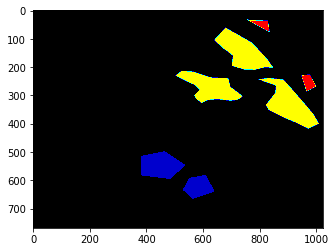

In [15]:

label_matrix_Level4_1=form_label_matrix(Level4_1_img,"Level4-1",df,1)


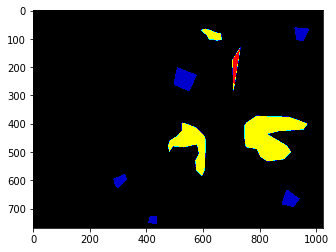

In [16]:
label_matrix_Level4_3=form_label_matrix(Level4_3_img,"Level4-3",df,1)

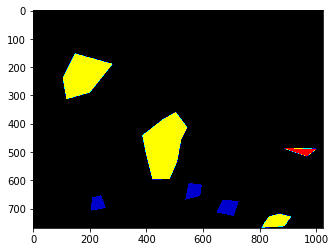

In [17]:
label_matrix_Level4_4=form_label_matrix(Level4_4_img,"Level4-4",df,1)

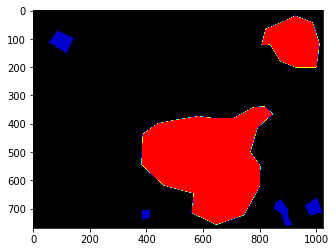

In [18]:
label_matrix_Level4_5=form_label_matrix(Level4_5_img,"Level4-5",df,1)

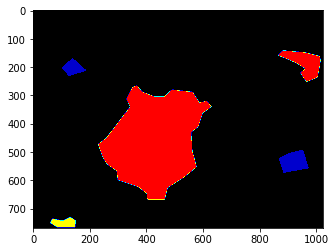

In [19]:
label_matrix_Level4_6=form_label_matrix(Level4_6_img,"Level4-6",df,1)

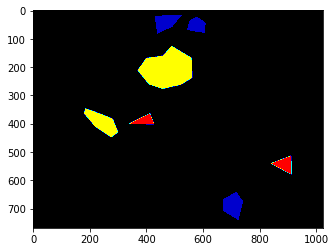

In [20]:
label_matrix_Level4_7=form_label_matrix(Level4_7_img,"Level4-7",df,1)

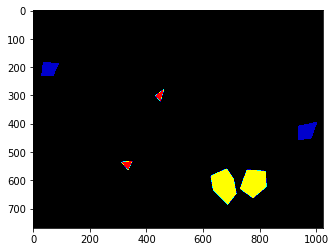

In [21]:
label_matrix_Level4_8=form_label_matrix(Level4_8_img,"Level4-8",df,1)

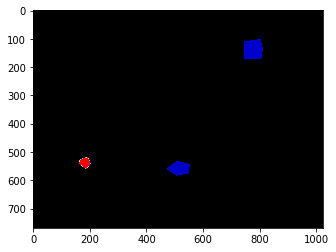

In [22]:
label_matrix_Level4_9=form_label_matrix(Level4_9_img,"Level4-9",df,1)

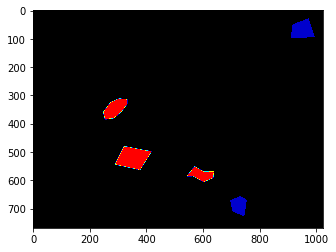

In [23]:
label_matrix_Level4_10=form_label_matrix(Level4_10_img,"Level4-10",df,1)

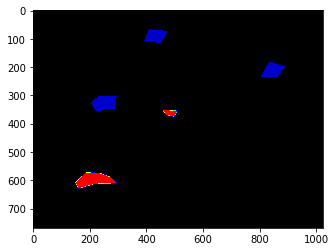

In [24]:
label_matrix_Peeling_1=form_label_matrix(Peeling_1_img,"Peeling-1",df,1)

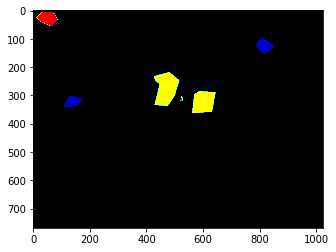

In [25]:
label_matrix_Peeling_2=form_label_matrix(Peeling_2_img,"Peeling-2",df,1)

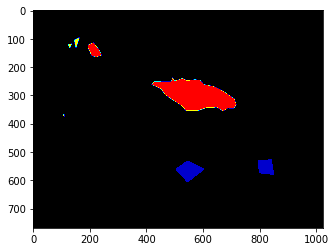

In [26]:
label_matrix_Peeling_4=form_label_matrix(Peeling_4_img,"Peeling-4",df,1)

## clipping

In [27]:
def flat_label_matrix(label_matrix):
  label_matrix_flat=label_matrix.reshape( (label_matrix.shape[0]*label_matrix.shape[1],1) )
  return label_matrix_flat


In [28]:
# flat label matrix 
label_matrix_Level4_1_flat=flat_label_matrix(label_matrix_Level4_1)
label_matrix_Level4_3_flat=flat_label_matrix(label_matrix_Level4_3)
label_matrix_Level4_4_flat=flat_label_matrix(label_matrix_Level4_4)
label_matrix_Level4_5_flat=flat_label_matrix(label_matrix_Level4_5)
label_matrix_Level4_6_flat=flat_label_matrix(label_matrix_Level4_6)
label_matrix_Level4_7_flat=flat_label_matrix(label_matrix_Level4_7)
label_matrix_Level4_8_flat=flat_label_matrix(label_matrix_Level4_8)
label_matrix_Level4_9_flat=flat_label_matrix(label_matrix_Level4_9)
label_matrix_Level4_10_flat=flat_label_matrix(label_matrix_Level4_10)

label_matrix_Peeling_1_flat=flat_label_matrix(label_matrix_Peeling_1)
label_matrix_Peeling_2_flat=flat_label_matrix(label_matrix_Peeling_2)

label_matrix_Peeling_4_flat=flat_label_matrix(label_matrix_Peeling_4)



In [29]:
# remove rows with zero index 
def generate_X_y(img_refl_input,label_matrix_flat):

  index0_list=np.where(label_matrix_flat==0)[0].tolist()
  y_img=np.delete(label_matrix_flat,index0_list,axis=0)
  X_img=np.delete(img_refl_input,index0_list,axis=0)
  

  return X_img,y_img






In [30]:
X_img_Level4_1,y_img_Level4_1=generate_X_y( Level4_1_img_refl_input , label_matrix_Level4_1_flat )
X_img_Level4_3,y_img_Level4_3=generate_X_y( Level4_3_img_refl_input , label_matrix_Level4_3_flat )
X_img_Level4_4,y_img_Level4_4=generate_X_y( Level4_4_img_refl_input , label_matrix_Level4_4_flat )
X_img_Level4_5,y_img_Level4_5=generate_X_y( Level4_5_img_refl_input , label_matrix_Level4_5_flat )
X_img_Level4_6,y_img_Level4_6=generate_X_y( Level4_6_img_refl_input , label_matrix_Level4_6_flat )
X_img_Level4_7,y_img_Level4_7=generate_X_y( Level4_7_img_refl_input , label_matrix_Level4_7_flat )
X_img_Level4_8,y_img_Level4_8=generate_X_y( Level4_8_img_refl_input , label_matrix_Level4_8_flat )
X_img_Level4_9,y_img_Level4_9=generate_X_y( Level4_9_img_refl_input , label_matrix_Level4_9_flat )
X_img_Level4_10,y_img_Level4_10=generate_X_y( Level4_10_img_refl_input , label_matrix_Level4_10_flat )


X_img_Peeling_1,y_img_Peeling_1=generate_X_y( Peeling_1_img_refl_input , label_matrix_Peeling_1_flat )
X_img_Peeling_2,y_img_Peeling_2=generate_X_y( Peeling_2_img_refl_input , label_matrix_Peeling_2_flat )

X_img_Peeling_4,y_img_Peeling_4=generate_X_y( Peeling_4_img_refl_input , label_matrix_Peeling_4_flat )

In [31]:
# concatinate 
X = np.concatenate((X_img_Level4_1,X_img_Level4_3,X_img_Level4_4,X_img_Level4_5,X_img_Level4_6,X_img_Level4_7,X_img_Level4_8,X_img_Level4_9,X_img_Level4_10,X_img_Peeling_1,X_img_Peeling_2,X_img_Peeling_4),0)
#concatinate triplets
y = np.concatenate((y_img_Level4_1,y_img_Level4_3,y_img_Level4_4,y_img_Level4_5,y_img_Level4_6,y_img_Level4_7,y_img_Level4_8,y_img_Level4_9,y_img_Level4_10,y_img_Peeling_1,y_img_Peeling_2,y_img_Peeling_4),0)

In [32]:
#shuffel 
## shuffle 
def my_shuff(X,y):
  X_shuf=np.zeros(X.shape)
  y_shuf=np.zeros(y.shape)

  arr = np.arange(len(y))
  np.random.shuffle(arr)
  counter=0

  for i in arr:
    X_shuf[counter,:]=X[i,:]
    y_shuf[counter]=y[i]
    counter=counter+1;
  
  return X_shuf,y_shuf


In [33]:
#shuffel
X_shuf,y_shuf=my_shuff(X,y)
X_shuf,y_shuf=my_shuff(X_shuf,y_shuf)
X_shuf,y_shuf=my_shuff(X_shuf,y_shuf)

In [34]:
# data split 
X_train, X_test, y_train, y_test=splitTrainTestSet(X_shuf,y_shuf, testRatio=0.1, randomState=345) 

In [38]:
sum(y_train==6)
print( y_train.shape)

(539267, 1)


In [39]:
X_train=X_train[:-1,:]
y_train=y_train[:-1]

In [40]:
print( y_train.shape)

(539266, 1)


# Training

In [41]:
# batched inputs 

'''
the important parts are ensuring that data is not repeated in an epoch and all the data is used in each epoch. Otherwise the model might overfit to some particular data and could be worse at generalizing to unseen testing data. Tracking the indices is just a simple way to achieve this goal. Another approach would be to shuffle the data at the beginning of each epoch. Whatever works. 
It just looked like your example code was potentially reusing some data and neglecting other data within an epoch.
'''



'\nthe important parts are ensuring that data is not repeated in an epoch and all the data is used in each epoch. Otherwise the model might overfit to some particular data and could be worse at generalizing to unseen testing data. Tracking the indices is just a simple way to achieve this goal. Another approach would be to shuffle the data at the beginning of each epoch. Whatever works. \nIt just looked like your example code was potentially reusing some data and neglecting other data within an epoch.\n'

In [42]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#input related parameters

input_size = 21 
num_classes = 6 # 4 for short
sequence_length= 3 

# Hyper-parameters 

hidden_size =  128
hidden_size1 =  64
num_epochs = 80
batch_size= 26

learning_rate = 0.001
num_layers= 2

# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size,hidden_size1, num_layers, num_classes):
        super(RNN, self).__init__()
        self.layers=num_layers 
        self.hidden_size=hidden_size
        self.hidden_size1=hidden_size1
        #self.rnn=nn.RNN( input_size, hidden_size, num_layers, batch_first=True )  # (batch, seq, feature) or false (seq,batch,features)
        self.gru = nn.GRU( input_size, hidden_size, num_layers, batch_first=True )
        #self.rnn=nn.RNN( input_size, hidden_size, num_layers, batch_first=True ) 
        self.linear=nn.Linear( self.hidden_size , self.hidden_size1 )
        self.linear1=nn.Linear( self.hidden_size1 , num_classes )

    
    def forward(self, x):
        hidden=torch.zeros( self.layers, batch_size , self.hidden_size  ).to(device) # (num_layers , seq_length or batch ? , hidden_size) 
        
        out, _  = self.gru( x , hidden) # x : ( seq ,features) 
        #out, _  = self.rnn( x , hidden) # x : ( seq ,features) 

        out = out[:, -1, :]
        # out: (n, 128)
        out = self.linear1(self.linear(  out    ))
        return out

model = RNN(input_size, hidden_size,hidden_size1, num_layers, num_classes).to(device) 
model=model.float()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_correct = 0
n_samples = 0
for epoch in range(num_epochs):
      #X_train_flip
      samples=torch.from_numpy(X_train) 
      permutation = torch.randperm(samples.size()[0])

      for i in range(0,samples.size()[0], batch_size):
          
          indices=permutation[i:i+batch_size]

          sample_batch = samples[indices,:]
       
          sample_batch = sample_batch.reshape( -1, sequence_length , input_size ).to(device) # (batch, seq, feature)
          
          outputs = model(sample_batch.float())

          labels_batch = torch.tensor(y_train[indices] - 1)
          labels_batch = labels_batch.type(torch.LongTensor).to(device)

          
          # Forward pass
        
          
          loss = criterion(outputs, labels_batch.reshape(-1))
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          _,prediction=torch.max(outputs.data,1)
          n_samples+=labels_batch.reshape(-1).size(0)
          n_correct+= (prediction==labels_batch.reshape(-1)).sum().item()
          
      acc = 100.0 * n_correct / n_samples
      print(f'Epoch : {epoch} Accuracy of the network s: {acc} Loss: {loss.item():.4f} ')
      
      n_correct = 0
      n_samples = 0




Epoch : 0 Accuracy of the network s: 97.740076325969 Loss: 0.0443 
Epoch : 1 Accuracy of the network s: 98.90221152455375 Loss: 0.0055 
Epoch : 2 Accuracy of the network s: 99.07986040284386 Loss: 0.0024 
Epoch : 3 Accuracy of the network s: 99.16979746544376 Loss: 0.0047 
Epoch : 4 Accuracy of the network s: 99.24675392107049 Loss: 0.0082 


KeyboardInterrupt: ignored

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

all_pred=torch.tensor([])
with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
   
    samples=torch.from_numpy(X_train_flip) 
   # permutation = torch.randperm(samples.size()[0]) # no need for permutation here

    for i in range(0,samples.size()[0], batch_size):
        
        

        sample_batch = samples[i:i+batch_size,:]
        sample_batch = sample_batch.reshape( -1, sequence_length , input_size ).to(device) # (batch, seq, feature)
        outputs = model(sample_batch.float())

        labels_batch = torch.tensor(y_train[i:i+batch_size]-1).to(device)
        labels_batch = labels_batch.type(torch.LongTensor)
        # max returns (value ,index)

        _, predicted = torch.max(outputs.data, 1)
        all_pred=torch.cat((all_pred,predicted),0)
        n_samples += labels_batch.size(0)
        n_correct += (predicted == labels_batch.reshape(-1)).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

# save model

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
torch.save(model.state_dict(),f'/content/saved_model/modelgru_short_80epochs.pth')

# Testing

## on test dataset 

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#input related parameters

input_size = 21 
num_classes = 6 
sequence_length= 3 

# Hyper-parameters 

hidden_size =  128
hidden_size1 =  64
num_epochs = 80
batch_size=1000

learning_rate = 0.001
num_layers= 2

# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size,hidden_size1, num_layers, num_classes):
        super(RNN, self).__init__()
        self.layers=num_layers 
        self.hidden_size=hidden_size
        self.hidden_size1=hidden_size1
        #self.rnn=nn.RNN( input_size, hidden_size, num_layers, batch_first=True )  # (batch, seq, feature) or false (seq,batch,features)
        self.gru = nn.GRU( input_size, hidden_size, num_layers, batch_first=True )
        #self.rnn=nn.RNN( input_size, hidden_size, num_layers, batch_first=True ) 
        self.linear=nn.Linear( self.hidden_size , self.hidden_size1 )
        self.linear1=nn.Linear( self.hidden_size1 , num_classes )

    
    def forward(self, x):
        hidden=torch.zeros( self.layers, batch_size , self.hidden_size  ).to(device) # (num_layers , seq_length or batch ? , hidden_size) 
        
        out, _  = self.gru( x , hidden) # x : ( seq ,features) 
        #out, _  = self.rnn( x , hidden) # x : ( seq ,features) 

        out = out[:, -1, :]
        # out: (n, 128)
        out = self.linear1(self.linear(  out    ))
        return out

model = RNN(input_size, hidden_size,hidden_size1, num_layers, num_classes).to(device) 
model=model.float()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/modelgru_80epochs.pth',map_location=torch.device('cpu') ))
model.eval()

RNN(
  (gru): GRU(21, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=64, bias=True)
  (linear1): Linear(in_features=64, out_features=6, bias=True)
)

In [ ]:
print(y_test.shape)

(58691, 1)


In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

all_pred=torch.tensor([])
with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
   
    samples=torch.from_numpy(X_test) 
   # permutation = torch.randperm(samples.size()[0]) # no need for permutation here

    for i in range(0,samples.size()[0], batch_size):
        
        

        sample_batch = samples[i:i+batch_size,:]
        sample_batch = sample_batch.reshape( -1, sequence_length , input_size ).to(device) # (batch, seq, feature)
        outputs = model(sample_batch.float())

        labels_batch = torch.tensor(y_test[i:i+batch_size]-1).to(device)
        labels_batch = labels_batch.type(torch.LongTensor).to(device)
        # max returns (value ,index)

        _, predicted = torch.max(outputs.data, 1)
        all_pred=torch.cat((all_pred.to(device),predicted),0)
        n_samples += labels_batch.size(0)
        n_correct += (predicted == labels_batch.reshape(-1)).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 96.19853037088569 %


In [ ]:



target_names = ['Level 1','Level 3','Level 4','background']
print( classification_report( torch.tensor(y_train-1).reshape(-1).cpu() , all_pred.cpu(),target_names=target_names ) )


              precision    recall  f1-score   support

     Level 1       0.96      0.98      0.97    108281
     Level 2       0.92      0.94      0.93     32080
     Level 3       0.96      0.90      0.93     50030
     Level 4       0.97      0.99      0.98     20478
  background       1.00      1.00      1.00      9212
         sky       1.00      1.00      1.00      9909

    accuracy                           0.96    229990
   macro avg       0.97      0.97      0.97    229990
weighted avg       0.96      0.96      0.96    229990



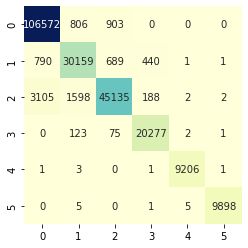

In [ ]:
import seaborn as sns
matrix_confusion = confusion_matrix(torch.tensor(y_train-1).reshape(-1).cpu(), all_pred.cpu())
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='YlGnBu', fmt='d', cbar=False)

## on images

In [ ]:
draw=1
  #  1,2, 3, 4 , b,s
Level1_1_img.shape[0]*Level1_1_img.shape[1]

786432

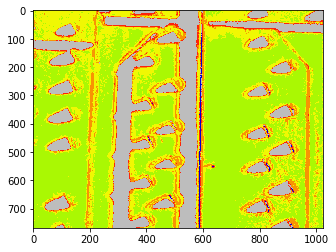

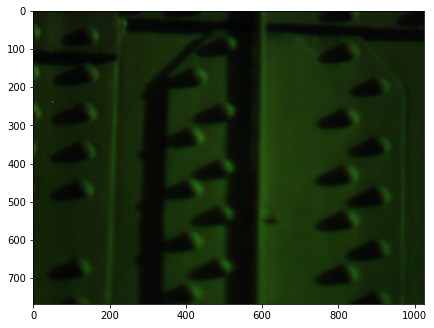

In [ ]:
batch_size=1024
predict_image(Level1_1_img,batch_size,sequence_length,input_size,draw)

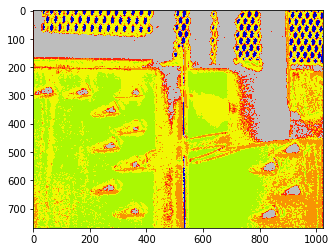

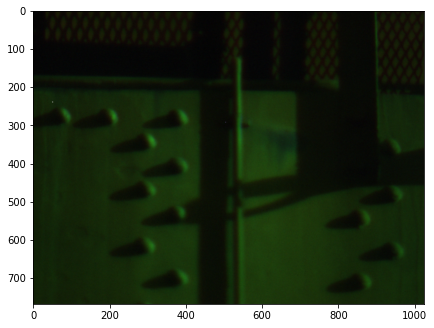

In [ ]:

predict_image(Level2_1_img,batch_size,sequence_length,input_size,draw)

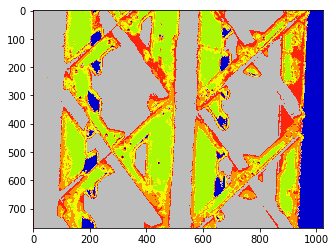

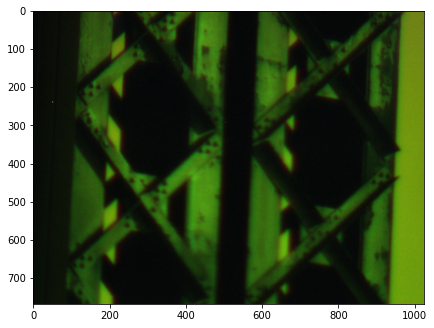

In [ ]:

predict_image(Mixture_1_img,batch_size,sequence_length,input_size,draw)


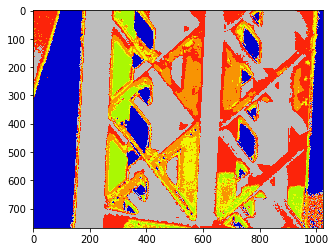

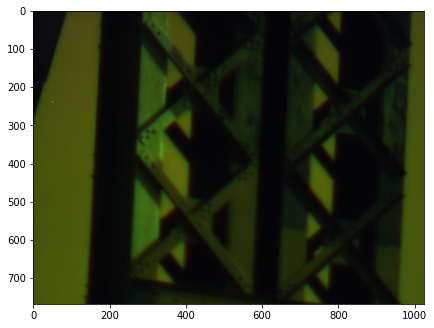

In [ ]:
predict_image(Mixture_2_img,draw)

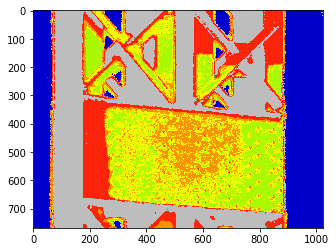

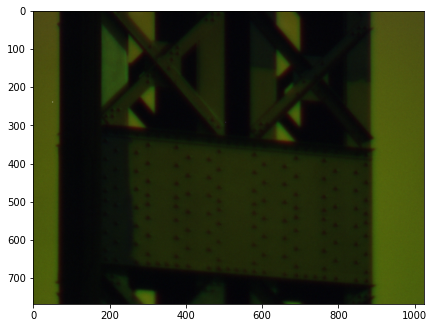

In [ ]:
predict_image(Mixture_3_img,draw)

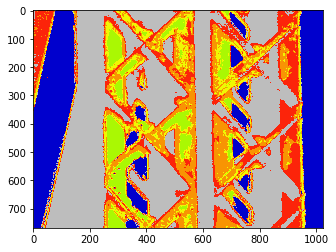

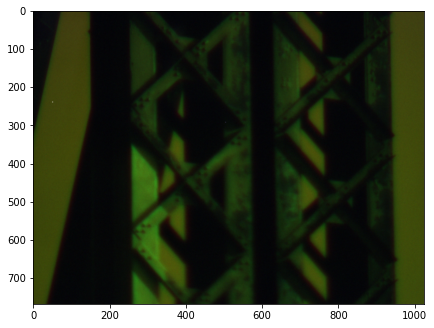

In [ ]:
predict_image(Mixture_4_img,draw)

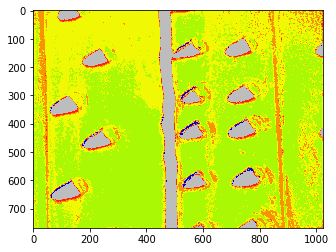

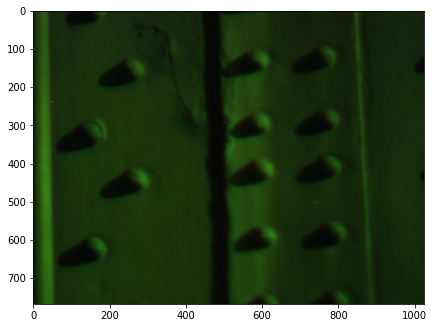

In [ ]:
predict_image(Mixture_5_img,draw)

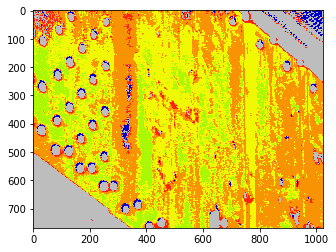

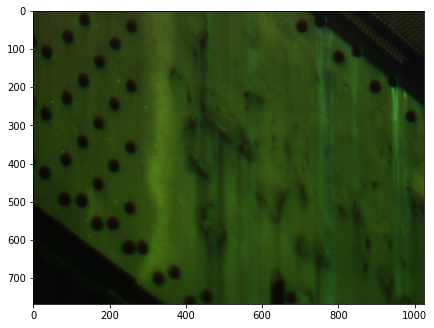

In [ ]:
predict_image(Peeling_1_img,draw)

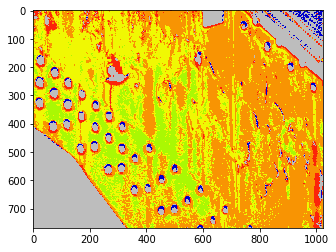

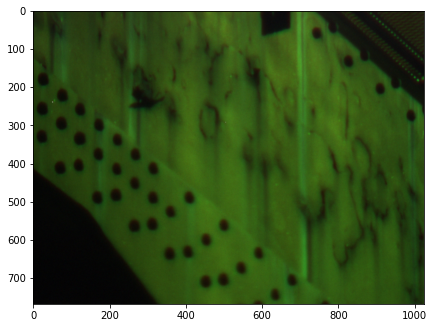

In [ ]:
predict_image(Peeling_2_img,draw)

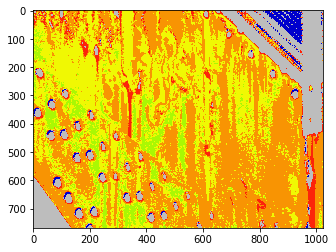

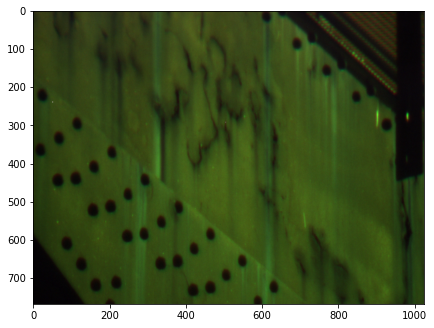

In [ ]:
predict_image(Peeling_3_img,draw)

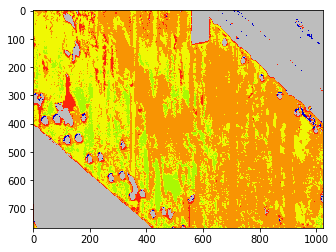

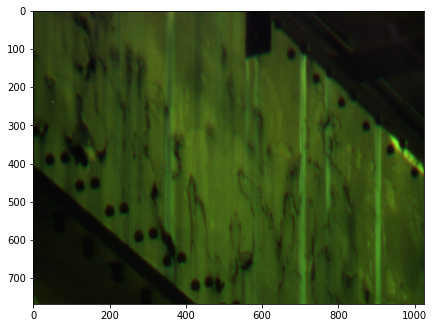

In [ ]:
predict_image(Peeling_4_img,draw)

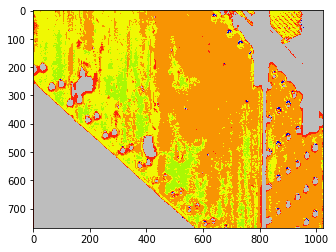

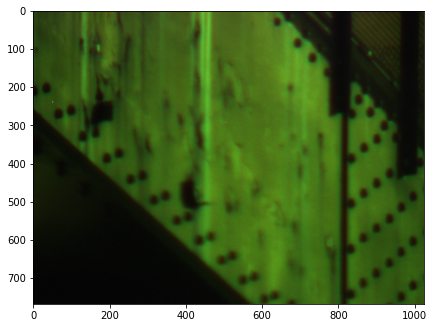

In [ ]:

predict_image(Peeling_5_img,batch_size,sequence_length,input_size,draw)

# Inference speed

In [ ]:
N_batch=1000
batched_input=X_shuf[0:N_batch]
print(batched_input.shape)

(1000, 63)


In [ ]:
import time
def predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=10, N_run=100):

  elapsed_time = []
  all_preds = []
  batch_size = batched_input.shape[0] 

  batched_input=torch.from_numpy(batched_input.reshape( -1, sequence_length , input_size )).float()

  for i in range(N_warmup_run):
    
    outputs = infer(batched_input)

  for i in range(N_run):
    start_time = time.time()

    outputs = infer(batched_input)

    #preds = labeling['dense_4'].numpy()

    end_time = time.time()

    elapsed_time = np.append(elapsed_time, end_time - start_time)
    
    #all_preds.append(preds)

    if i % 50 == 0:
      if i != 0:
           print('Steps {}-{} average: {:4.1f}ms'.format(i-50, i, (elapsed_time[-50:].mean()) * 1000))

  print('Throughput: {:.0f} pixels/s'.format(N_run * batch_size / elapsed_time.sum()))
  #return all_preds

In [ ]:
predict_and_benchmark_throughput(batched_input, model, N_warmup_run=10, N_run=1000)

Steps 0-50 average: 28.4ms
Steps 50-100 average: 41.2ms
Steps 100-150 average: 38.0ms
Steps 150-200 average: 28.0ms
Steps 200-250 average: 27.9ms
Steps 250-300 average: 27.6ms
Steps 300-350 average: 38.1ms
Steps 350-400 average: 31.3ms
Steps 400-450 average: 27.5ms
Steps 450-500 average: 27.5ms
Steps 500-550 average: 27.8ms
Steps 550-600 average: 27.5ms
Steps 600-650 average: 27.7ms
Steps 650-700 average: 27.8ms
Steps 700-750 average: 28.1ms
Steps 750-800 average: 27.6ms
Steps 800-850 average: 27.9ms
Steps 850-900 average: 28.3ms
Steps 900-950 average: 28.3ms
Throughput: 33641 pixels/s
